In [11]:
from dictionaries import *
from helper_functions import *
from produce_datasets import *
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
import os
os.chdir('/home/cj/Documents/dsi/capstones/report-card-recession')

In [2]:
def add_qtrid(df):
    '''
    adds a column for the year and quarter.

    params: df(dataframe)
    returns: dataframe with column added'''
    df['qtrid'] = df['year'] + (df['qtr']/4)
    return df

def import_one(year):
    '''brings a single year's woth of data into a dataframe. Used for initial EDA. 
    Referenced in import_all

    params: year(str)
    returns: df(dataframe)'''
    filepath = '../data/area_files/' + str(year) + '.csv'
    #all relevant csvs are renamed with only the year
    df = pd.read_csv(filepath, dtype = schema_dict)
    #schema_dict is found in dictionaries.py
    for column in drop_columns:
        if column in df.columns:
            df = df.drop([column], axis = 1)
    return df

def import_all(years):
    '''combines as many years of data into a single dataframe, as well as adding quater id
    References import_one and add_qtrid

    params: years (list of str)
    returns: df (dataframe)'''
    df = import_one(years[0])
    for year in years[1:]:
        df = df.append(import_one(year))
    df = add_qtrid(df)
    return df

In [3]:
def create_timeline_2001(variable):
    '''produces a dataframe of the 2001 recession timeline.
    
    .0Used to compute targets

    params: variable, str, one of ['month3_emplvel' (employment), 'avg_wkly_wage' (wages)]
    returns: df, Dataframe
    exports a json file (used in plotting results)
    '''
    
    #create a dataframe of the years in question
    df = import_all(recession1_years)

    #drop 'unknown or undefined' areas
    df = df[~df['area_fips'].str.contains("999")]
    
    #pivots the table to arrange quarters in columns, drops extraneous variables.
    df = df.pivot_table(columns = 'qtrid', values = variable, index = ['area_fips', 'area_title'], aggfunc = np.sum)
    df = df.reset_index()
    
    #fill nans
    df = df.fillna(0)

    #creates a secondary dataframe with only timeline variables
    df2 = df.drop(columns = ['area_fips', 'area_title'])
    df2 = df2.reset_index()
    
    #drops the index so that all calculations are free of any type mismatches
    df2 = df2.drop(columns = 'index')
    df2 = df2.fillna(0)

### DEPRECIATED CODE #### 

#     #this specifies when the jobs numbers "bottom-out" during the recession
#     nadir = df2.iloc[:,6:].apply(lambda x: calc_nadir(x), axis=1).rename('nadir')
    
#     #counts the number of quarters to the nadir since the beginning of the timeframe
#     nadir_qtr = df2.iloc[:,6:].apply(lambda x: calc_nadir_qtr(x), axis=1).rename('nadir_qtr')
    
#     #computes the highest points before and after the nadir, and captures the quarter count
#     pre_peak = df2.apply(lambda x: calc_pre_peak(x), axis=1).rename('pre_peak')
#     pre_peak_qtr = df2.apply(lambda x: calc_pre_peak_quarter(x), axis=1).rename('pre_peak_qtr')
#     post_peak = df2.apply(lambda x: calc_post_peak(x), axis=1).rename('post_peak')
#     post_peak_qtr = df2.apply(lambda x: calc_post_peak_qtr(x), axis=1).rename('post_peak_qtr')

### DEPRECIATED CODE #### 
    
    #specifies the lowest job numbers during the recession. Disregards quarters before the recession event. 
    df2['nadir'] = df2.iloc[:,6:].min(axis=1)

    #specifies which quarter the nadir occured.
    df2['nadir_qtr'] = df2.iloc[:,6:].idxmin(axis=1).apply(lambda x: df.columns.get_loc(x))
    
    #creates a column to store indices for lookup.
    df2['new'] = [df2.iloc[i].values for i in df.index]
  
    #specifies the highest job numbers *before* the nadir.
    df2['pre_peak'] = df2.apply(lambda x: max(x['new'][0:x['nadir_qtr']]), axis=1)
    
    #creates a column to derive the recovery quarter
    df2['recovery_list'] = df2.apply(lambda x: (x['new'][x['nadir_qtr']:] > x['pre_peak']), axis=1)

    # df2['recovery_qtr'] = next((i for i, j in enumerate(list(df2['recovery_list'])) if j), None)

    #specifies the highest job numbers *after* the nadir
    df2['post_peak'] = df2.apply(lambda x: max(x['new'][x['nadir_qtr']:]), axis=1)
    
    #specifies which quarter the pre-peak occurred.
    df2['pre_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['pre_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    
    #specifies which quarter the post-peak occurred.
    df2['post_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['post_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    
    #creates a new dataset to store derived fields
    df_new = df2[['nadir', 'nadir_qtr', 'pre_peak', 'pre_peak_qtr', 'recovery_list', 'post_peak', 'post_peak_qtr', 'new']]
    
    #puts the computed points in a dataframe, joins with timeline
    df = df.join(df_new, how = 'outer', rsuffix = '_derive')
    
    #PRIMARY TARGET: did the area decline the entire time(-1), did it start growing again but not avhieve it's former numbers(0), or did it grow and recover(1)?
    df['recovery'] = (df['post_peak'] >= df['pre_peak']) *1

    #SECONDARY TARGET: How long did the jobs numbers decline?
    df['decline'] = (df['nadir_qtr'] - df['pre_peak_qtr'])
    
    #TERTIARY TARGET: different in before/after jobs numbers
    df['delta'] = df['post_peak'] - df['pre_peak']
    
    #export the data
    # df.to_json('data/Recession1_timeline.json')
    return df

In [4]:
df = create_timeline_2001('month3_emplvl')
    

In [5]:
    # df2['recovery_list'] = df2.apply(lambda x: (x['new'][x['nadir_qtr']:] > x['pre_peak']), axis=1)

    # df2['recovery_qtr'] = list(df2['recovery_list']).index(next(filter(lambda i: i != 0, list(df2['recovery_list'])))) 

In [6]:
df_samp = df[df['recovery'] == 1]

In [7]:
df_samp['recovery_qtr'] = df_samp['recovery_list'].apply(lambda x: list(x).index(True))
df_samp['recovery_qtr'] = df_samp['recovery_qtr'] + df_samp['nadir_qtr']

ValueError: True is not in list

In [9]:
for index, row in df_samp.iterrows():
    print (index, np.sum(row['recovery_list']))

0 11
2 19
4 15
7 4
8 15
10 20
11 12
16 9
18 1
20 10
21 11
22 14
23 6
26 22
31 12
32 17
35 13
39 2
41 18
42 6
43 3
45 20
47 3
48 15
49 7
51 11
52 1
55 19
56 4
58 19
59 23
61 24
63 17
64 14
68 13
70 5
71 16
72 24
73 4
74 7
75 8
76 16
77 3
78 3
79 3
80 5
81 2
83 2
84 21
86 8
88 1
90 3
92 18
97 11
98 18
99 3
100 16
101 15
102 10
103 19
104 1
105 1
106 15
107 23
108 14
109 14
110 20
111 15
112 23
113 9
114 14
115 18
117 9
118 23
126 11
129 2
130 21
131 23
132 3
137 15
139 6
140 16
142 3
144 11
146 4
147 3
150 23
155 4
156 5
157 17
158 1
159 5
163 5
164 19
167 21
172 12
174 11
177 17
179 10
181 12
186 17
187 9
190 11
193 20
194 8
195 7
196 9
197 5
198 17
199 24
200 6
201 1
203 16
205 12
206 16
209 4
210 6
214 11
215 5
216 5
218 12
219 12
220 17
221 23
223 24
224 18
225 1
226 23
227 23
229 19
230 13
232 6
235 21
238 21
240 11
241 7
242 1
244 9
245 18
246 23
247 17
249 7
250 10
251 10
253 10
257 25
258 2
259 4
260 12
265 12
267 1
268 18
269 5
270 24
271 6
273 15
275 4
276 8
279 8
283 4
284 17


In [12]:
import matplotlib.pyplot as plt 
%matplotlib inline



In [ ]:
df_samp.columns

In [15]:
df_plot = df_samp.drop(columns = ['area_fips', 'area_title', 'nadir',
           'nadir_qtr',      'pre_peak',  'pre_peak_qtr', 'recovery_list',
           'post_peak', 'post_peak_qtr',           'new',      'recovery',
             'decline',         'delta'])



In [ ]:
df_samp['area_title'].iloc[0]

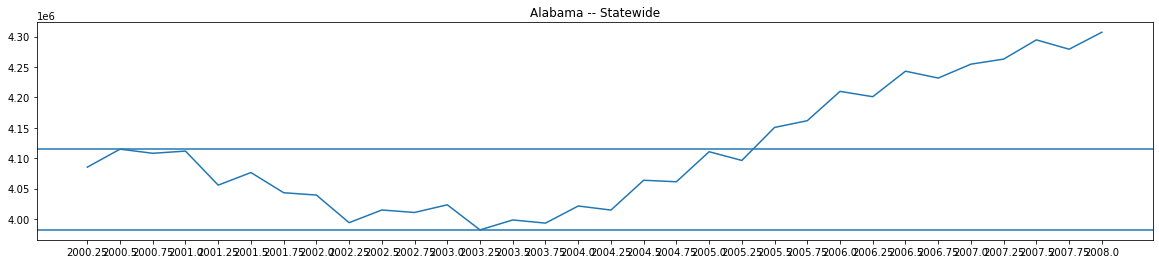

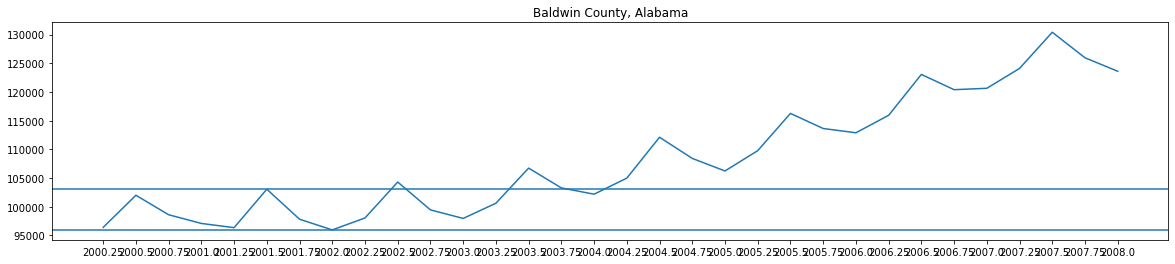

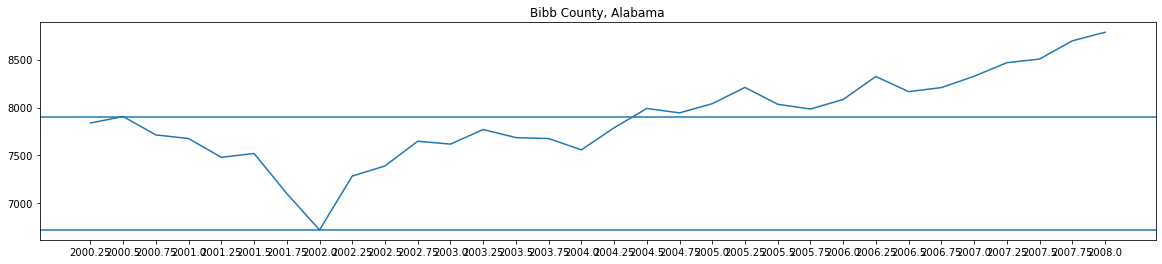

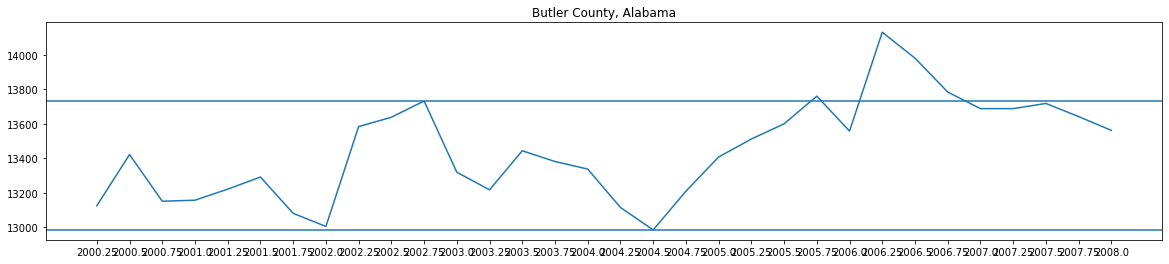

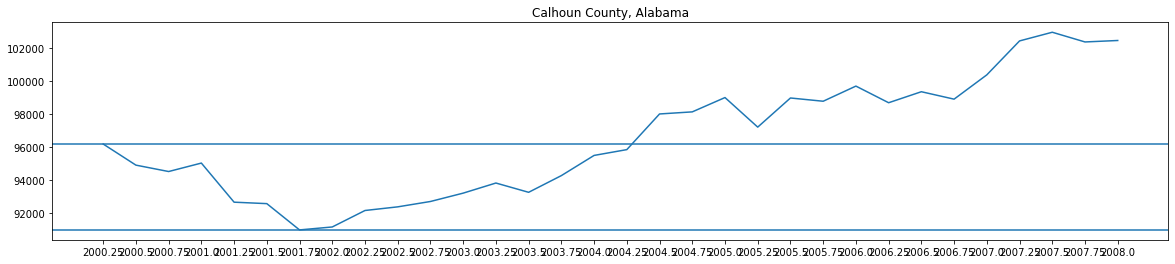

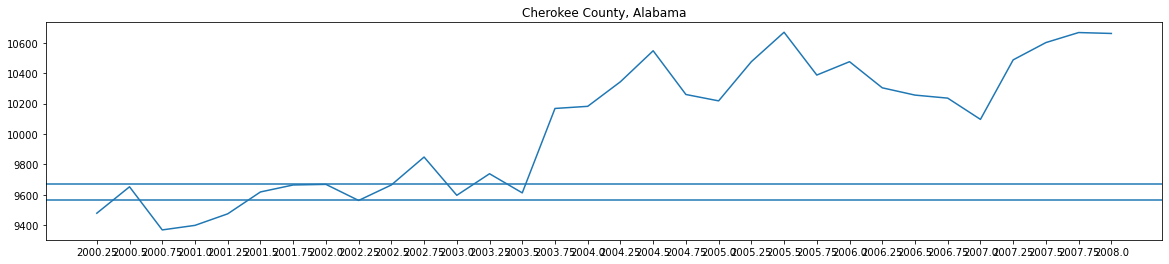

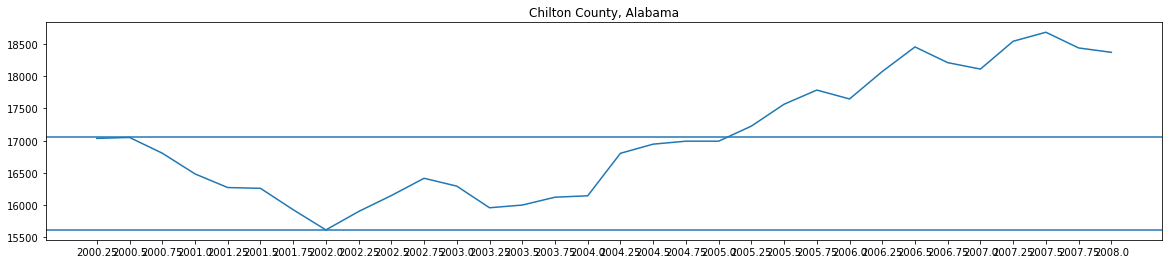

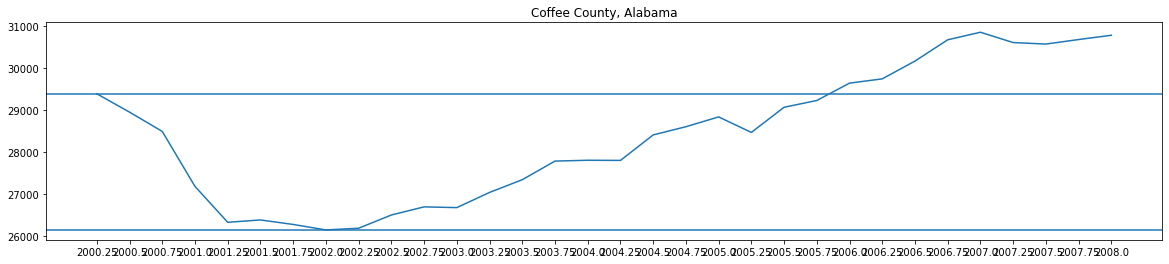

Error in callback <function flush_figures at 0x7f0f870cc9d0> (for post_execute):


KeyboardInterrupt: 

In [17]:
for check in range(0, 10):
    fig, ax = plt.subplots(figsize = (20,4))
    ax.plot(['2000.25', '2000.5', '2000.75', '2001.0', '2001.25', '2001.5', '2001.75', '2002.0', '2002.25', '2002.5', '2002.75', '2003.0', '2003.25', '2003.5','2003.75', '2004.0', '2004.25', '2004.5', '2004.75', '2005.0', '2005.25', '2005.5', '2005.75', '2006.0', '2006.25', '2006.5', '2006.75', '2007.0', '2007.25','2007.5', '2007.75', '2008.0'], df_plot.iloc[check])
    plt.title(df_samp['area_title'].iloc[check])
    ax.axhline(y =df_samp['nadir'].iloc[check])
    ax.axhline(y =df_samp['pre_peak'].iloc[check])
    # ax.axvline(x = str(((df_samp['recovery_qtr'].iloc[check])  /4 ) + 2000.25))
    ax.legend;

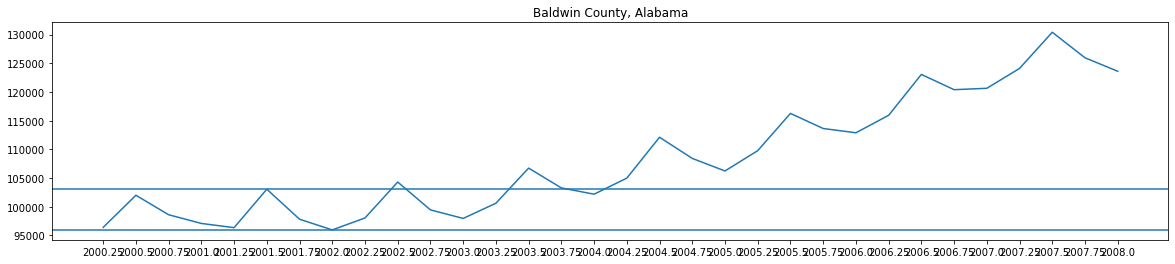

In [22]:
    check = 2
    fig, ax = plt.subplots(figsize = (20,4))
    ax.plot(['2000.25', '2000.5', '2000.75', '2001.0', '2001.25', '2001.5', '2001.75', '2002.0', '2002.25', '2002.5', '2002.75', '2003.0', '2003.25', '2003.5','2003.75', '2004.0', '2004.25', '2004.5', '2004.75', '2005.0', '2005.25', '2005.5', '2005.75', '2006.0', '2006.25', '2006.5', '2006.75', '2007.0', '2007.25','2007.5', '2007.75', '2008.0'], df_plot.loc[check])
    plt.title(df_samp['area_title'].loc[check])
    ax.axhline(y =df_samp['nadir'].loc[check])
    ax.axhline(y =df_samp['pre_peak'].loc[check])
    # ax.axvline(x = str(((df_samp['recovery_qtr'].loc[check])  /4 ) + 2000.25))
    ax.legend;


In [ ]:

  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# finding first True value 
# using filter() + lamda + index() 
res = list(df_samp['recovery_list'][0]).index(next(filter(lambda i: i != 0, df_samp['recovery_list'][0])))
  
# printing result 
print ("The values till first True value : " + str(res)) 

In [ ]:
# biggest_vals = df_empl.transpose().iloc[0:8,:].max(axis=0)
# ending = (df_empl.transpose() > biggest_vals).idxmax()
# biggest_idx = df_wages.T.iloc[0:8,:].idxmax()